We use "PDEFIND" method here to "discover" swift hohenberg from
its numerical simulations. Swift-Hohenberg reads
$$ u_t = -(\Delta+1)^2 u + Ru - u^3 $$
$$ \\ u_t = -\Delta^2 u -2\Delta u + (R-1)u - u^3 $$

Our feature matrix will have the terms
$$1, u, u^2, u^3, u_x, u_y, u_x^2, u_y^2, u_y u_x, u_{xx}, u_{yy}, u_{xy},
 \Delta u, \Delta^2 u$$

 We use $$R=.5$$ for the data generation.

 Similar to previous experiment, but speeding up date collection

data shape:  (256, 256, 201)


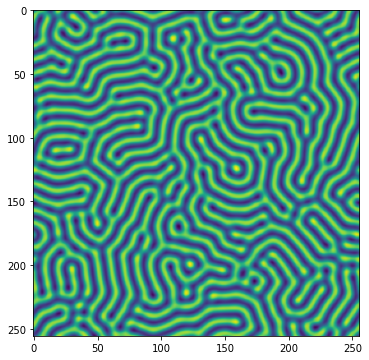

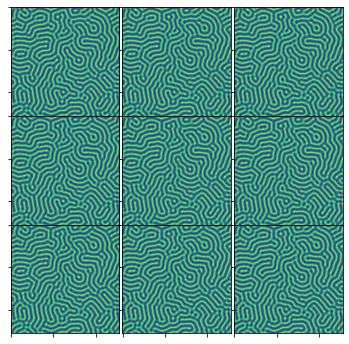

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from myPDEFIND import *
import math

data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/sh1.mat")

t = data['tt'].T[:,0]
x = data['xx'].T[0,:]
y = data['yy'].T[0,:]
U = data['uu']
print("data shape: ",np.shape(U))

nx = len(x)
ny = len(y)
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]

#plot solution
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax1.imshow(U[:,:,100])

#validate periodicity- this means spectral derivatives are fine
fig = plt.figure(figsize=(6,6))
ax = [plt.subplot(3,3,i+1) for i in range(9)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')
plt.subplots_adjust(wspace=0,hspace=0)
ax[0].imshow(U[:,:,100])
ax[1].imshow(U[:,:,100])
ax[2].imshow(U[:,:,100])
ax[3].imshow(U[:,:,100])
ax[4].imshow(U[:,:,100])
ax[5].imshow(U[:,:,100])
ax[6].imshow(U[:,:,100])
ax[7].imshow(U[:,:,100])
ax[8].imshow(U[:,:,100])

In [8]:
#take 25 evenly spaced apart time samples,
#and construct matrix on coarse grid of spatial features

num_t = 20
x_subsample = 8
y_subsample = 8
t_vals = np.arange(1,len(t),math.floor(len(t)/num_t))
x_vals = np.arange(0,nx,x_subsample)
y_vals = np.arange(0,ny,y_subsample)

num_points = num_t*len(x_vals)*len(y_vals)
print("feature vec length: ",num_points)

u = np.zeros((num_points,1))
u_t = np.zeros((num_points,1))
u_x = np.zeros((num_points,1))
u_y = np.zeros((num_points,1))
u_xx = np.zeros((num_points,1))
u_yy = np.zeros((num_points,1))
u_xy = np.zeros((num_points,1))
lapu = np.zeros((num_points,1))
biharmu = np.zeros((num_points,1))


# setting parameters for spectral derivatives
Lx = 2*x[len(x)-1] # Size of enclosing periodic rectangle
Ly = 2*y[len(y)-1]

i=0
for t_idx in t_vals:
    print(t_idx)
    uu = U[:,:,t_idx]
    uu_t = BackwardDiff(U[:,:,t_idx],U[:,:,t_idx-1],dt)
    uu_x = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'x')
    uu_y = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'y')
    uu_xx = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'xx')
    uu_yy = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'yy')
    uu_xy = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'xy')
    lapuu = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'laplacian')
    biharmuu = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'biharmonic')
    for x_idx in x_vals:
        for y_idx in y_vals:
            u[i] = uu[x_idx,y_idx]
            u_t[i] = uu_t[x_idx,y_idx]
            u_x[i] = uu_x[x_idx,y_idx]
            u_y[i] = uu_y[x_idx,y_idx]
            u_xx[i] = uu_xx[x_idx,y_idx]
            u_yy[i] = uu_yy[x_idx,y_idx]
            u_xy[i] = uu_xy[x_idx,y_idx]
            lapu[i] = lapuu[x_idx,y_idx]
            biharmu[i] = biharmuu[x_idx,y_idx]
            i+=1

feature vec length:  20480
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191


Consruct $\Theta(U)$
We use for our library
$$ 1, u, u^2, u^3, u^4, u_x, u_y $$
$$u_x^2, u_y^2, u_yu_x, u_{xx}, u_{yy}, u_{xy}, \Delta u, \Delta^2 u$$

In [9]:
X = np.hstack([np.ones((num_points,1)), u, u**2, u**3,u**4,
                   u_x, u_y, u_x**2, u_y**2, u_x*u_y,
                   u_xx, u_yy, u_xy, lapu, biharmu])
description = ['','u','u^2','u^3','u^4',
               'u_{x}','u_{y}','u_{x}^2','u_{y}^2','u_{x}u_{y}',
               'u_{xx}','u_{yy}','u_{xy}','lapu','biharmu']

['1'] + description[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u^4',
 'u_{x}',
 'u_{y}',
 'u_{x}^2',
 'u_{y}^2',
 'u_{x}u_{y}',
 'u_{xx}',
 'u_{yy}',
 'u_{xy}',
 'lapu',
 'biharmu']

In [10]:
c = TrainSTRidge(X,u_t,10**-5,1)
print_pde(c, description)

u_t = (-0.500065 +0.000000i)u
    + (-1.008778 +0.000000i)u^3
    + (-70.973725 +0.000000i)u_{xx}
    + (-70.973663 +0.000000i)u_{yy}
    + (68.965229 +0.000000i)lapu
    + (-1.004243 +0.000000i)biharmu
   


In [11]:
X2 = np.hstack([np.ones((num_points,1)), u, u**2, u**3,u**4,
                   u_x, u_y, u_x**2, u_y**2, u_x*u_y,u_xy, lapu, biharmu])
description2 = ['','u','u^2','u^3','u^4',
               'u_{x}','u_{y}','u_{x}^2','u_{y}^2','u_{x}u_{y}','u_{xy}','lapu','biharmu']

['1'] + description2[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u^4',
 'u_{x}',
 'u_{y}',
 'u_{x}^2',
 'u_{y}^2',
 'u_{x}u_{y}',
 'u_{xy}',
 'lapu',
 'biharmu']

In [12]:
c2 = TrainSTRidge(X2,u_t,10**-5,1)
print_pde(c2, description2)


u_t = (-0.500052 +0.000000i)u
    + (-1.008770 +0.000000i)u^3
    + (-2.008435 +0.000000i)lapu
    + (-1.004231 +0.000000i)biharmu
   
